In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import timm
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Custom Dataset for HCAL Data with Augmentation
class HCALDataset(Dataset):
    def __init__(self, data, labels, augment=False):
        self.data = data
        self.labels = labels
        self.augment = augment
        
        self.transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(degrees=20),
        ])
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]
        
        image = torch.from_numpy(image).float()
        
        if self.augment:
            image = self.transform(image)
            
        return image, label

In [3]:
# Loading and Preprocessing of the data
def load_and_preprocess_data():
    
    run1_data = np.load("/kaggle/input/dataset/Run355456_Dataset_jqkne (1).npy")
    run2_data = np.load("/kaggle/input/dataset/Run357479_Dataset_iodic.npy")   
    print(f"Run 1 shape: {run1_data.shape}")
    print(f"Run 2 shape: {run2_data.shape}")   
    run1_labels = np.zeros(run1_data.shape[0])
    run2_labels = np.ones(run2_data.shape[0])   
    X = np.vstack((run1_data, run2_data))
    y = np.concatenate((run1_labels, run2_labels))
    X = X.reshape(X.shape[0], 1, X.shape[1], X.shape[2])
    X_max = np.max(X)
    X = X / X_max if X_max > 0 else X    
    X = np.log1p(X)     
    y = y.astype(np.int64)
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)
    
    train_set = {tuple(img.flatten()) for img in X_train}
    val_set = {tuple(img.flatten()) for img in X_val}
    test_set = {tuple(img.flatten()) for img in X_test}

    assert train_set.isdisjoint(val_set), "Data leakage detected between training and validation sets!"
    assert train_set.isdisjoint(test_set), "Data leakage detected between training and test sets!"
    assert val_set.isdisjoint(test_set), "Data leakage detected between validation and test sets!"

    print("No data leakage detected.")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [4]:
print("Loading and preprocessing data...")
X_train, X_val, X_test, y_train, y_val, y_test = load_and_preprocess_data()

Loading and preprocessing data...
Run 1 shape: (10000, 64, 72)
Run 2 shape: (10000, 64, 72)
No data leakage detected.


Visualizing sample images...


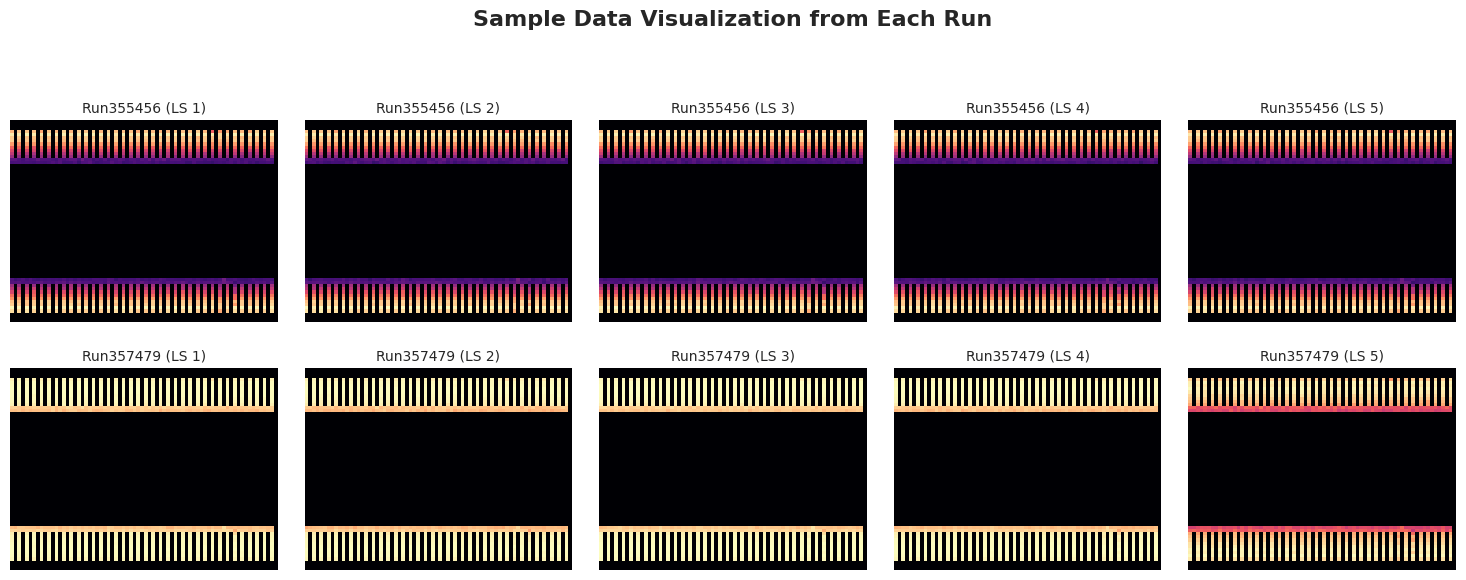

In [5]:
# Visualization of data_samples
def visualize_samples(X_train, y_train, num_samples=5):
    sns.set_style("whitegrid") 
    sns.set_context("talk") 
    
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    fig.suptitle("Sample Data Visualization from Each Run", fontsize=16, fontweight="bold")

    class0_indices = np.where(y_train == 0)[0]
    class1_indices = np.where(y_train == 1)[0]

    num_samples = min(num_samples, len(class0_indices), len(class1_indices))

    for i in range(num_samples):
 
        sns.heatmap(X_train[class0_indices[i], 0], 
                    cmap="magma", ax=axes[0, i], cbar=False, xticklabels=False, yticklabels=False)
        axes[0, i].set_title(f"Run355456 (LS {i+1})", fontsize=10)
        
        sns.heatmap(X_train[class1_indices[i], 0], 
                    cmap="magma", ax=axes[1, i], cbar=False, xticklabels=False, yticklabels=False)
        axes[1, i].set_title(f"Run357479 (LS {i+1})", fontsize=10)


        for spine in axes[0, i].spines.values():
            spine.set_visible(False)
        for spine in axes[1, i].spines.values():
            spine.set_visible(False)

    plt.subplots_adjust(hspace=0.4, wspace=0.1)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  
    plt.savefig('sample_images.png', dpi=300, bbox_inches='tight')
    plt.show()


print("Visualizing sample images...")
visualize_samples(X_train, y_train)

In [6]:
# Loading  a smaller ViT(Vision Transformer) model 
class HCALViT(nn.Module):
    def __init__(self, num_classes=2, pretrained=False):
        super(HCALViT, self).__init__()
        
        
        self.vit = timm.create_model(
            'vit_tiny_patch16_224',  
            pretrained=pretrained,
            img_size=(64, 72),  
            in_chans=1,         
            num_classes=0,      
            patch_size=4        
        )
        self.feature_dim = self.vit.embed_dim
        self.layer_norm = nn.LayerNorm(self.feature_dim)
        self.classifier = nn.Sequential(
            nn.Linear(self.feature_dim, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(0.3), 
            nn.Linear(256, num_classes)
        )    
    def forward(self, x):
        features = self.vit(x)  
        features = self.layer_norm(features)  
        out = self.classifier(features)  
        return out
        

In [7]:
# Create datasets and dataloaders
train_dataset = HCALDataset(X_train, y_train,augment=True)
val_dataset = HCALDataset(X_val, y_val)
test_dataset = HCALDataset(X_test, y_test)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

print("Initializing ViT model...")
model = HCALViT(num_classes=2).to(device)

Initializing ViT model...


In [8]:
# Training function for the model
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    best_val_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_epoch_loss = val_loss / len(val_loader.dataset)
        val_epoch_acc = val_correct / val_total
        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_epoch_acc)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
              f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

        if scheduler is not None:
            scheduler.step()

        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            torch.save(model.state_dict(), 'CustomViT_model.pth')
            print(f"Model saved with validation accuracy: {best_val_acc:.4f}")

    return history


In [9]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
num_epochs = 10
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

print("Starting training...")
history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)

Starting training...


Epoch 1/10 - Validation: 100%|██████████| 63/63 [00:03<00:00, 17.79it/s]


Epoch 1/10, Train Loss: 0.1028, Train Acc: 0.9708, Val Loss: 0.0139, Val Acc: 0.9942
Model saved with validation accuracy: 0.9942


Epoch 2/10 - Validation: 100%|██████████| 63/63 [00:03<00:00, 17.85it/s]


Epoch 2/10, Train Loss: 0.0063, Train Acc: 0.9994, Val Loss: 0.0074, Val Acc: 1.0000
Model saved with validation accuracy: 1.0000


Epoch 3/10 - Validation: 100%|██████████| 63/63 [00:03<00:00, 17.61it/s]


Epoch 3/10, Train Loss: 0.0045, Train Acc: 0.9997, Val Loss: 0.0007, Val Acc: 1.0000


Epoch 4/10 - Validation: 100%|██████████| 63/63 [00:03<00:00, 17.76it/s]


Epoch 4/10, Train Loss: 0.0015, Train Acc: 1.0000, Val Loss: 0.0008, Val Acc: 1.0000


Epoch 5/10 - Validation: 100%|██████████| 63/63 [00:03<00:00, 17.77it/s]


Epoch 5/10, Train Loss: 0.0012, Train Acc: 1.0000, Val Loss: 0.0007, Val Acc: 1.0000


Epoch 6/10 - Validation: 100%|██████████| 63/63 [00:03<00:00, 17.78it/s]


Epoch 6/10, Train Loss: 0.0010, Train Acc: 1.0000, Val Loss: 0.0007, Val Acc: 1.0000


Epoch 7/10 - Validation: 100%|██████████| 63/63 [00:03<00:00, 17.84it/s]


Epoch 7/10, Train Loss: 0.0008, Train Acc: 1.0000, Val Loss: 0.0006, Val Acc: 1.0000


Epoch 8/10 - Validation: 100%|██████████| 63/63 [00:03<00:00, 17.72it/s]


Epoch 8/10, Train Loss: 0.0008, Train Acc: 1.0000, Val Loss: 0.0005, Val Acc: 1.0000


Epoch 9/10 - Validation: 100%|██████████| 63/63 [00:03<00:00, 17.76it/s]


Epoch 9/10, Train Loss: 0.0008, Train Acc: 1.0000, Val Loss: 0.0005, Val Acc: 1.0000


Epoch 10/10 - Validation: 100%|██████████| 63/63 [00:03<00:00, 17.82it/s]

Epoch 10/10, Train Loss: 0.0008, Train Acc: 1.0000, Val Loss: 0.0005, Val Acc: 1.0000


In [10]:
# Evaluating the model performance of Test dataset
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probabilities[:, 1].cpu().numpy())  
            all_labels.extend(labels.cpu().numpy())
    

    accuracy = accuracy_score(all_labels, all_preds)
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    cm = confusion_matrix(all_labels, all_preds)

    # Plot Confusion Matrix as a Heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix Heatmap")
    plt.savefig("confusion_matrix_CustomViT.png")
    plt.show()

    # Plot Confusion Matrix Histogram
    plt.figure(figsize=(6, 4))
    plt.hist(cm.flatten(), bins=10, color='blue', alpha=0.7)
    plt.xlabel("Count")
    plt.ylabel("Frequency")
    plt.title("Confusion Matrix Histogram")
    plt.savefig("confusion_matrix_histogram_CustomViT.png")
    plt.show()

    # Plot ROC curve
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig('roc_curve_CustomViT.png')
    plt.show()
    
    return accuracy, roc_auc, fpr, tpr


In [11]:
# Plotting the losses and accuracy
def plot_training_history(history):
    """Plots training and validation loss & accuracy"""
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training & Validation Loss")
    plt.savefig('Loss_CustomViT.png')
    plt.show()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Val Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig('Accuracy_CustomViT.png')
    plt.title("Training & Validation Accuracy")
    plt.tight_layout()
    plt.show()


Plotting training history...


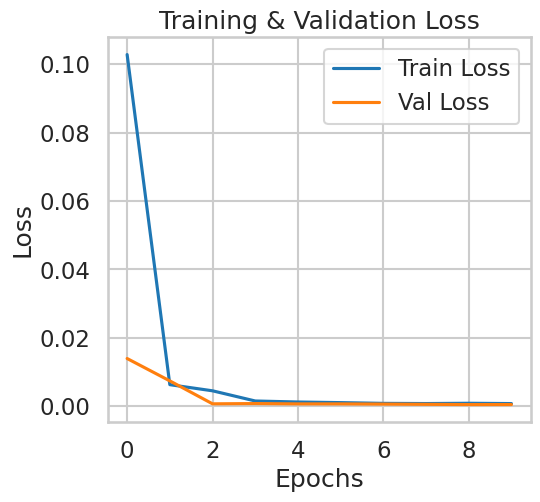

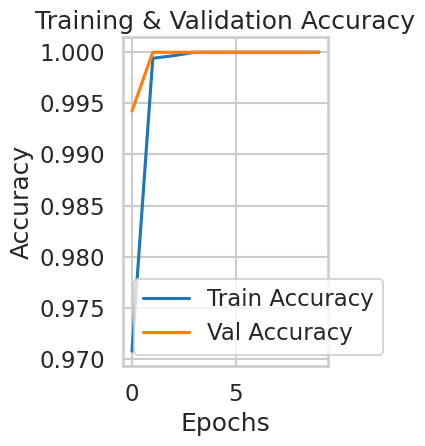

Evaluating model on test set...


Evaluating: 100%|██████████| 63/63 [00:03<00:00, 17.71it/s]


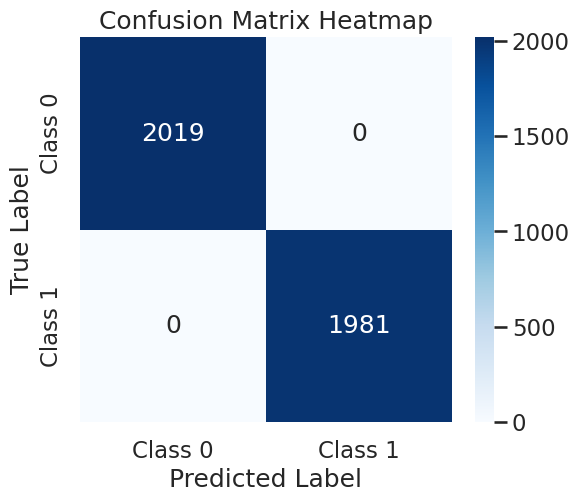

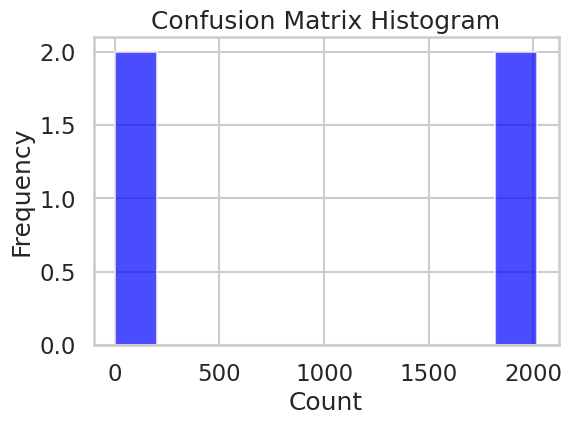

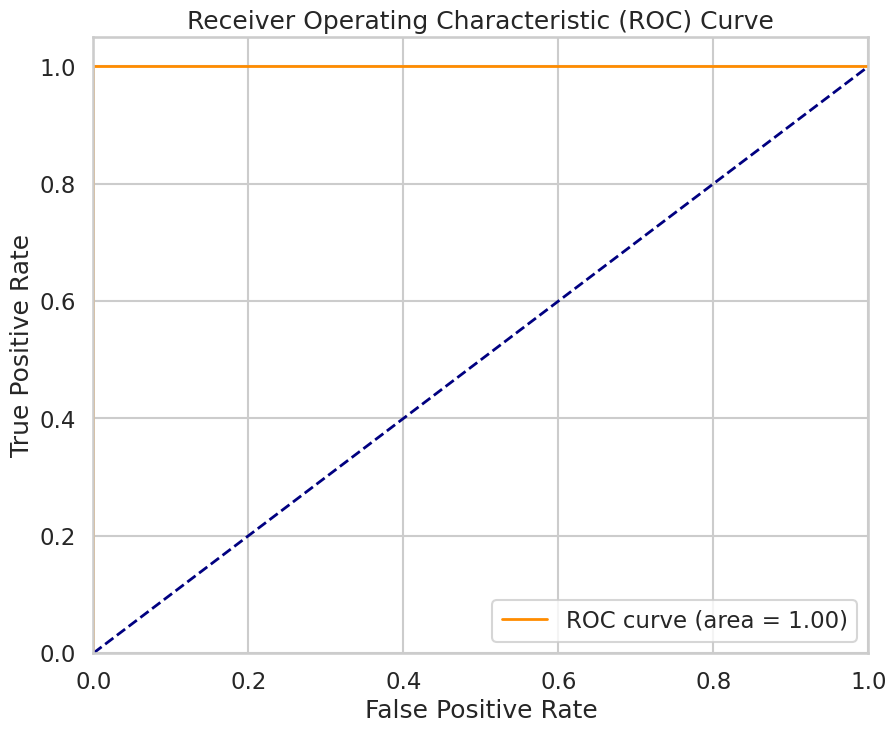

Test Accuracy: 1.0000
ROC AUC: 1.0000


In [12]:
print("Plotting training history...")
plot_training_history(history)


print("Evaluating model on test set...")
accuracy, roc_auc, fpr, tpr = evaluate_model(model, test_loader)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

with open('evaluation_metrics_CustomViT.txt', 'w') as f:
    f.write(f"Test Accuracy: {accuracy:.4f}\n")
    f.write(f"ROC AUC: {roc_auc:.4f}\n")
